# Project: Analyse the protein-protein interactions in yeast
## Nikolaos Gialitsis ##
## Data Analytics ###

### Load all necessary packages ###

In [1]:
#!/usr/bin/env python
#@Author: Nikolas Gialitsis #

import pandas as pd
import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import numpy as np
import networkx as nx
import sys
from scipy.optimize import curve_fit

### Define the ProteinNetwork Class ###

In [2]:
def powerlaw(x, alpha, beta, x0):
    if beta < 0 :
        beta = -beta
    return (x + x0)**alpha * np.exp(-beta *x)


class ProteinNetwork:

    def __init__(self,dataset):

        self.Propagation_matrix = []
        self.colored_nodes = []
        self.network = nx.Graph()
        self.length = len(dataset[(list(dataset)[0])].tolist())
        self.interactions = self.network.edges()
        self.proteins = self.network.nodes()
        self.degrees = self.network.degree()
        edges = []
        for x in xrange(0,self.length):
            source = (dataset[(list(dataset)[0])].tolist())[x]
            target = (dataset[(list(dataset)[1])].tolist())[x]
            edges.append((source,target))
        self.network.add_edges_from(edges)

    def show_degree_centrality(self):

        n_color = np.asarray([self.degrees[n] for n in self.proteins])

        print "\n\nmin degree ="+ str(min(n_color))
        print "max degree ="+ str(max(n_color))
        print str([x == min(n_color)  for x in n_color].count(1))+ " nodes have minimum degree centralities"
        print str([x == max(n_color)  for x in n_color].count(1))+ " nodes nodes have maximum degree centralities"	
        maxitem = 0
        for x in n_color:
            if x == max(n_color):
                break
            maxitem+=1
        start = maxitem
        print 'node with maximum degrees = ' + str(maxitem) + " with num of degrees = "+ str(max(n_color))

        fixed_positions = {1: (maxitem,max(n_color))}#dict with two of the positions set
        fixed_nodes = fixed_positions.keys()
        pos = nx.spring_layout(self.network,pos=fixed_positions, fixed = fixed_nodes)

        plt.figure("Protein interactions in Yeast")
        plt.title("Protein interactions in Yeast")
        plt.subplot(211)
        nx.draw(self.network,pos = pos ,node_color=n_color, nodelist = self.proteins,cmap='coolwarm',with_labels=False,node_size= n_color,width = 0.1)

        Affected = []

        for i in xrange(0,max(self.proteins)+1):
            self.Propagation_matrix.append(0)
            Affected.append(0)

        self.propagate_color(start)
        print "Propagation from point " + str(start) + "  affected "+str(self.Propagation_matrix.count(1)) + " nodes"
        Affected[maxitem] = self.Propagation_matrix.count(1)
        prop_array = np.asarray([p for p in self.Propagation_matrix])
        n_color_2 =  np.asarray([self.degrees[n] for n in self.colored_nodes])
        plt.subplot(212)
        G2 = self.network.copy()
        for e in self.interactions:
            if (e[0] not in self.colored_nodes ) and (e[1] not in self.colored_nodes):
                G2.remove_edge(e[0],e[1])
        nx.draw(G2,pos = pos,node_color=n_color_2, nodelist = self.colored_nodes,cmap='coolwarm',with_labels=False,node_size= n_color_2,width = 0.1)
        plt.show(block=True)




    def show_color_propagation(self):
        Affected = []
        if self.Propagation_matrix == []:
            for i in xrange(0,max(self.proteins)+1):
                self.Propagation_matrix.append(0)
                Affected.append(0)
        
        for start in self.proteins:
            for i in xrange(0,max(self.proteins)+1):
                self.Propagation_matrix[i] = 0
                Affected.append(0)
            self.propagate_color(start)
            print "Propagation from point " + str(start) + "  affected "+str(self.Propagation_matrix.count(1)) + " nodes"
            Affected[start] = self.Propagation_matrix.count(1)

        plt.xlabel("Starting Node")
        plt.ylabel("Nodes affected")
        plt.xlim(-1,2000)
        plt.ylim(-1,2000)
        plt.title("Number of nodes that can be affected from different starting points ")
        plt.plot(Affected,'ro')	


    def show_degree_distribution(self):
        n_color = np.asarray([self.degrees[n] for n in self.proteins])
        plt.figure("Power Law - degrees frequency")
        plt.title("Power Law - degrees frequency")
        plt.xlabel("Nodes")
        plt.ylabel("Degrees")
        x ,y  = np.unique(n_color, return_counts=True)
        plt.scatter(x,y,label = "degree count")
        parameters, fit  = curve_fit(powerlaw, x, y,maxfev = 3000)
        plt.plot(x, powerlaw(x, *parameters), label = "power_law",color = "r")
        plt.legend()
        plt.show()


    def show_graph_info(self):
        #print "Degree centrality = "+str(nx.algorithms.degree_centrality(self))
        print "Graph density = " + str(nx.density(self.network))
        print "Number of edges : " + str(len(self.interactions))
        print "Number of nodes: " + str(len(self.proteins))

    def show_closeness_centrality(self):
        closeness_centralities = []
        for n in self.proteins:
            closeness_centralities.append(nx.closeness_centrality(self.network, u=n))

        plt.figure("closeness centralities")
        plt.title("closeness centralities")
        plt.xlabel("nodes")
        plt.ylabel("degree centrality")

        print str([x == min(closeness_centralities)  for x in closeness_centralities].count(1))+ " nodes have minimum closeness centralities"
        print str([x == max(closeness_centralities)  for x in closeness_centralities].count(1))+ " nodes have maximum closeness centralities"

        max_centrality_node = 0
        for x in closeness_centralities:
            if x == max(closeness_centralities):
                break
            max_centrality_node+=1

        print "max centrality node = "+str(max_centrality_node)+ " with value : "+str(max(closeness_centralities)) + " and degree = " \
            +str(self.degrees[max_centrality_node])
        plt.scatter(max_centrality_node,max(closeness_centralities),color = "red",label = "best node",s = 20)
        plt.scatter(self.proteins,closeness_centralities,color = "blue" , label = "centralities",s = 2)
        plt.legend()
        plt.show(block=True)

        if len(closeness_centralities) != len(self.proteins):
            print 'error size'
            exit(-1)
        G3 = self.network.copy()
        for e in self.interactions:
            if closeness_centralities[e[0]-1] == 0.0:
                G3.remove_edge(e[0],e[1])
        sizes = [x * 50 for x in closeness_centralities]
        plt.figure("Closeness centralities Graph")
        plt.title("Closeness centralities Graph")
        nx.draw(G3,node_color= closeness_centralities ,nodelist = self.proteins,cmap='coolwarm',with_labels=False, \
            node_size= sizes, width = 0.1)
        plt.show(block=True)



    def show_betweeness_centrality(self):

        temp = nx.betweenness_centrality(self.network)
        inbetween_centralities = []
        for x in temp:
            inbetween_centralities.append(temp.get(x))

        plt.figure("inbetween centralities")
        plt.title("inbetween centralities")
        plt.xlabel("nodes")
        plt.ylabel("degree centrality")

        print str([x == min(inbetween_centralities)  for x in inbetween_centralities].count(1))+ " nodes have minimum betweenness centralities"
        print str([x == max(inbetween_centralities)  for x in inbetween_centralities].count(1))+ " nodes have maximum betweenness centralities"

        max_centrality_node = 0
        for x in inbetween_centralities:
            if x == max(inbetween_centralities):
                break
            max_centrality_node+=1

        print "max centrality node = "+str(max_centrality_node)+ " with value : "+str(max(inbetween_centralities)) + " and degree = " \
            +str(self.degrees[max_centrality_node])
        plt.scatter(max_centrality_node,max(inbetween_centralities),color = "red",label = "best node",s = 20)
        plt.scatter(self.proteins,inbetween_centralities,color = "blue" , label = "centralities",s = 2)
        plt.legend()
        plt.show(block=True)

        if len(inbetween_centralities) != len(self.proteins):
            print 'error size'
            exit(-1)

        G4 = self.network.copy()
        for e in self.interactions:
            if inbetween_centralities[e[0]-1] == 0.0:
                G4.remove_edge(e[0],e[1])

        sizes = [x * 100 for x in inbetween_centralities]
        plt.figure("inbetweeness centralities Graph")
        plt.title("inbetweeness centralities Graph")
        nx.draw(G4,node_color= inbetween_centralities ,nodelist = self.proteins,cmap='coolwarm',with_labels=False, \
            node_size= sizes, width = 0.1)
        plt.show(block=True)



    def show_pagerank(self):

        ranks = nx.pagerank(self.network)
        #print ranks
        plt.figure("PageRank")
        plt.title("PageRank")
        x = [r for r in ranks ]
        y = [ranks[r] for r in ranks ]
        print "maximum page rank  = " + str(max(y))

        best_node = 0
        for k in x :
            if ranks[k] == max(y):
                print "best page rank node =  " + str(k)
                best_node = k
                break

        plt.scatter(x,y,color = "blue", s = 1)
        plt.scatter(best_node,max(y),color = "red" , s = 5)
        plt.show()


        plt.figure("PageRank")
        plt.title("PageRank")
        yarray = np.asarray([k*5000 for k in y])
        xarray = np.asarray([k for k in x])

        nx.draw(self.network,node_color= yarray ,cmap='coolwarm',with_labels=False,node_size= yarray, width = 0.1)
        plt.show()

    def propagate_color(self,node):
        self.Propagation_matrix[node] = 1
        self.colored_nodes.append(node)
        neighbors = []
        for e in self.interactions: 
            if e[0] ==node:
                neighbors.append(e[1])
            elif e[1] == node:
                neighbors.append(e[0])

        for e in neighbors:
            if self.Propagation_matrix[e] == 1 :
                continue
            else:
                self.propagate_color(e)

### Process Input - Read from file ###

In [3]:
csv_file = "./out.protein_protein"
header_num = 0
while True:
    dataset=pd.read_csv(csv_file,delimiter= " ",header= header_num)
    if list(dataset)[0] == '%':
        header_num += 1
    else:
        break


### Create an instance of the class ###

In [4]:
G = ProteinNetwork(dataset)

### Show Basic Network's Information ###

In [5]:
G.show_graph_info()

Graph density = 0.0013024208662
Number of edges : 2276
Number of nodes: 1870


### Show that the degree distribution of the proteins follows a power law with exponential cuttoff ###

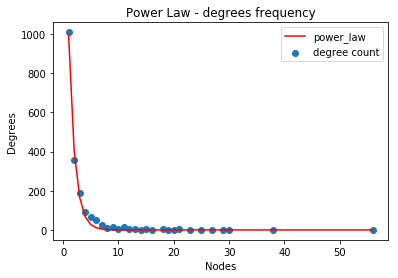

In [6]:
G.show_degree_distribution()

### Show Degree Centrality  of protein network ###



min degree =1
max degree =56
1010 nodes have minimum degree centralities
1 nodes nodes have maximum degree centralities
node with maximum degrees = 180 with num of degrees = 56
Propagation from point 180  affected 1458 nodes


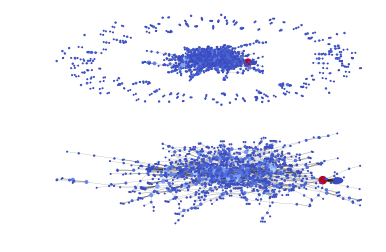

In [7]:
G.show_degree_centrality()

### Show Betweeness Centrality  of protein network ###

1124 nodes have minimum closeness centralities
1 nodes have maximum closeness centralities
max centrality node = 25 with value : 0.130445005365 and degree = 4


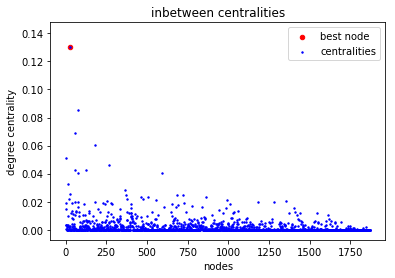

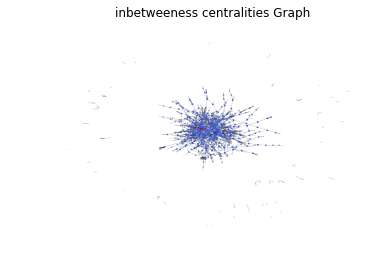

In [8]:
G.show_betweeness_centrality()

### Show Closeness Centrality of protein network ###

24 nodes have minimum closeness centralities
1 nodes have maximum closeness centralities
max centrality node = 25 with value : 0.183019780819 and degree = 4


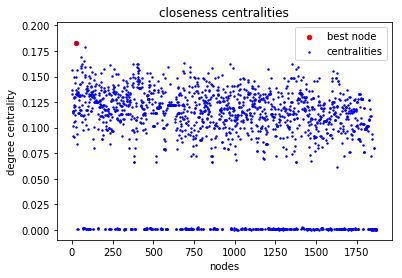

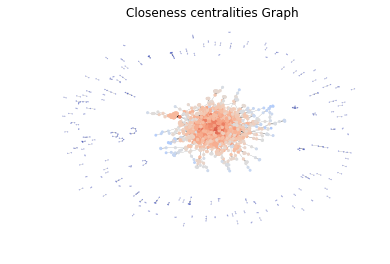

In [9]:
G.show_closeness_centrality()

### Calculate the PageRank score for every node ###

maximum page rank  = 0.0124715201311
best page rank node =  181


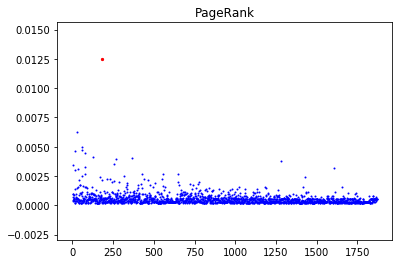

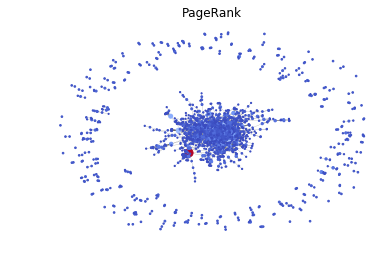

In [10]:
G.show_pagerank()